In [ ]:
# The MLP teacher model to predict the california housing dataset 

In [2]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

In [5]:
# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  
print(california_housing_data_train.shape)

(15722, 9)


In [6]:
# Perform the stratified 10 fold cross validation
number_of_folds = 10

kfolds = KFold(n_splits=number_of_folds)

x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [12]:
# Build the MLP model
def buildTeacherModel():
    model = models.Sequential()
    
    model.add(layers.Dense(256, activation='relu'))
    
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [13]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results = []

for i, (train_index, val_index) in enumerate(kfolds.split(x_train, y_train)):
    print(f"Fold {i}")

    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    teacher_model = buildTeacherModel()
    
    teacher_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.mean_absolute_error,
        metrics=['mse', 'mae', 'mape']
    )
    
    history = teacher_model.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs, 
        validation_data=(x_val_fold, y_val_fold)
    )
    
    # Record the result for each of 10 folds
    train_val_results.append(history.history)


Fold 0
443/443 [==============================] - 2s 2ms/step - loss: 10.2302 - mse: 1153.0803 - mae: 10.2302 - mape: 681.7759 - val_loss: 3.8595 - val_mse: 26.3639 - val_mae: 3.8595 - val_mape: 287.1872
Fold 1
443/443 [==============================] - 1s 2ms/step - loss: 2.4176 - mse: 25.7323 - mae: 2.4176 - mape: 161.4252 - val_loss: 0.6333 - val_mse: 0.6478 - val_mae: 0.6333 - val_mape: 44.2873
Fold 2
443/443 [==============================] - 1s 2ms/step - loss: 5.0094 - mse: 295.3478 - mae: 5.0094 - mape: 330.9015 - val_loss: 0.9582 - val_mse: 1.3650 - val_mae: 0.9582 - val_mape: 78.5689
Fold 3
443/443 [==============================] - 1s 2ms/step - loss: 9.8920 - mse: 303.9500 - mae: 9.8920 - mape: 653.6258 - val_loss: 22.4480 - val_mse: 811.5421 - val_mae: 22.4480 - val_mape: 1549.6155
Fold 4
443/443 [==============================] - 1s 2ms/step - loss: 6.2587 - mse: 113.5678 - mae: 6.2587 - mape: 417.1271 - val_loss: 5.4532 - val_mse: 49.0579 - val_mae: 5.4532 - val_mape: 33

In [14]:
teacher_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               2048      
                                                                 
 dense_37 (Dense)            (None, 32)                8224      
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,305
Trainable params: 10,305
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Retrain the model to evaluate the performance
teacher_model = buildTeacherModel()

teacher_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.mean_absolute_error,
    metrics=['mse', 'mae', 'mape']
)

history = teacher_model.fit(
    x_train, 
    y_train, 
    epochs=number_of_epochs
)

test_results = teacher_model.evaluate(x_test, y_test, return_dict= True)

prediction = teacher_model.predict(x_test)

rfScore=r2_score(y_test, prediction)
print(round(rfScore,2))

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - loss: 7.9905 - mse: 448.1076 - mae: 7.9905 - mape: 531.3705
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 5.3292 - mse: 81.0694 - mae: 5.3292 - mape: 352.1507
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 4.5640 - mse: 53.8978 - mae: 4.5640 - mape: 302.9914
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 3.1151 - mse: 25.6291 - mae: 3.1151 - mape: 206.5235
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 3.6833 - mse: 35.4421 - mae: 3.6833 - mape: 245.7085
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 3.1635 - mse: 27.0827 - mae: 3.1635 - mape: 209.4644
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 2.8923 - mse: 20.0695 - mae: 2.8923 - mape: 191.9611
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 3.0387 - mse: 26.9109 - mae:

Average Loss for training data for last epoch 0.4730263531208038+-0.00521713309891318
Average Loss for validation data for last epoch 0.47063357532024386+-0.01902017147565652
Average MSE for training data for last epoch 0.4109344959259033+-0.00626877372577386
Average MSE for validation data for last epoch 0.4168736606836319+-0.03376007469102447
MSE for testing data 0.4885738492012024


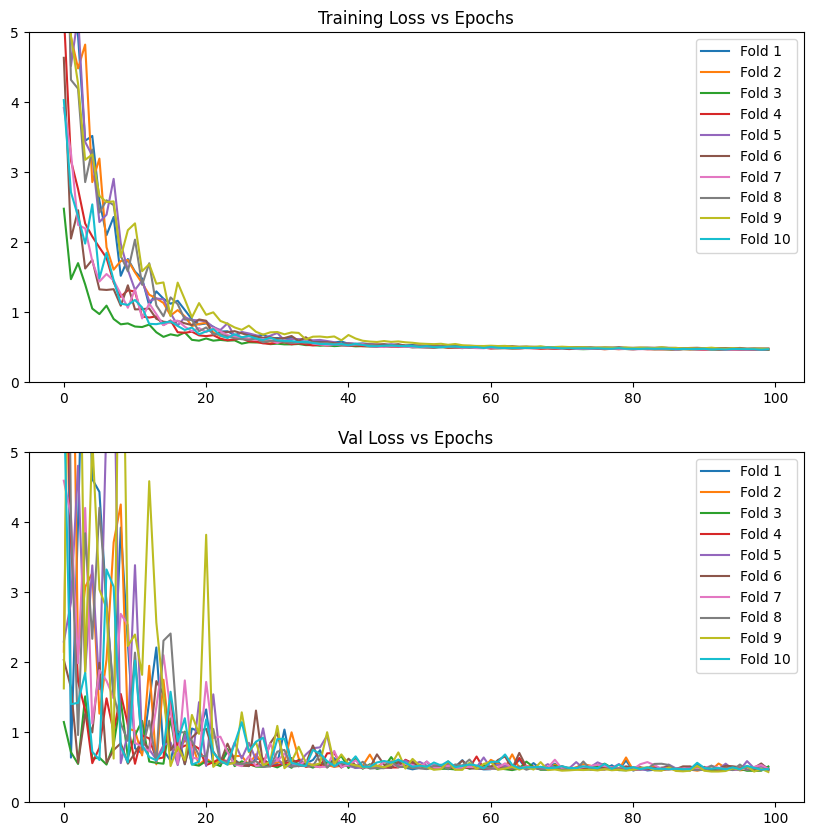

In [17]:
# Modified from source: https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
x = range(0, number_of_epochs)

# Training loss
x_legend = []
i = 1
for fold in [d['loss'] for d in train_val_results]:
    axs[0].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[0].title.set_text('Training Loss vs Epochs') 
axs[0].legend(x_legend)  
axs[0].set_ylim(0, 5)

# Validation loss
x_legend = []
i = 1
for fold in [d['val_loss'] for d in train_val_results]:
    axs[1].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[1].title.set_text('Val Loss vs Epochs') 
axs[1].legend(x_legend)  
axs[1].set_ylim(0, 5)

# Report the training std of the mse based on the last epoch of all folds 

# Get the last loss for training data of each fold 
train_loss_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results]]
# Get the last loss for validation data of each fold 
val_loss_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results]]

train_loss_stds = np.std(train_loss_last_epochs)
val_loss_stds = np.std(val_loss_last_epochs)

# Get the MSE for the training and valiation dataset
train_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results]]
val_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results]]

train_mse_stds = np.std(train_mse_last_epochs)
val_mse_stds = np.std(val_mse_last_epochs)

# Report loss
print(f"Average Loss for training data for last epoch {np.mean(train_loss_last_epochs)}"f"+-{np.mean(train_loss_stds)}")
print(f"Average Loss for validation data for last epoch {np.mean(val_loss_last_epochs)}"f"+-{np.mean(val_loss_stds)}")

# Report MSE
print(f"Average MSE for training data for last epoch {np.mean(train_mse_last_epochs)}"f"+-{np.mean(train_mse_stds)}")
print(f"Average MSE for validation data for last epoch {np.mean(val_mse_last_epochs)}"f"+-{np.mean(val_mse_stds)}")

print(f"MSE for testing data {test_results['mse']}")

(0.0, 5.0)

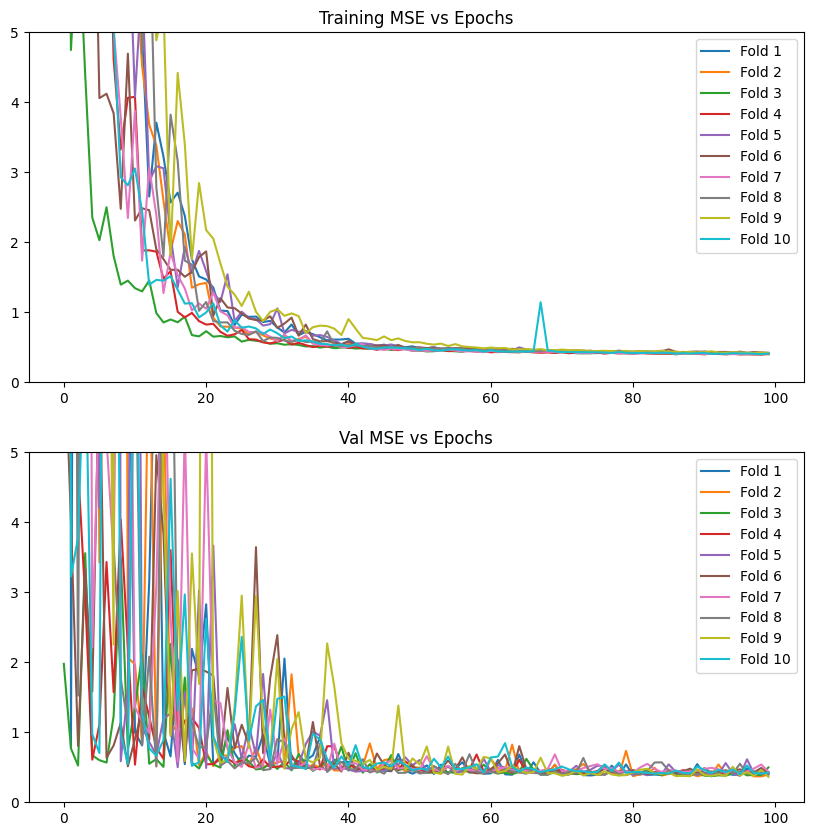

In [21]:
# Modified from source: https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
x = range(0, number_of_epochs)

# Training mse
x_legend = []
i = 1
for fold in [d['mse'] for d in train_val_results]:
    axs[0].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[0].title.set_text('Training MSE vs Epochs') 
axs[0].legend(x_legend)  
axs[0].set_ylim(0, 5)

# Validation loss
x_legend = []
i = 1

for fold in [d['val_mse'] for d in train_val_results]:
    axs[1].plot(x, fold, '-') 
    x_legend.append(f"Fold {i}")
    i = i+1
    
axs[1].title.set_text('Val MSE vs Epochs') 
axs[1].legend(x_legend)  
axs[1].set_ylim(0, 5)

Text(0, 0.5, 'Predicted values')

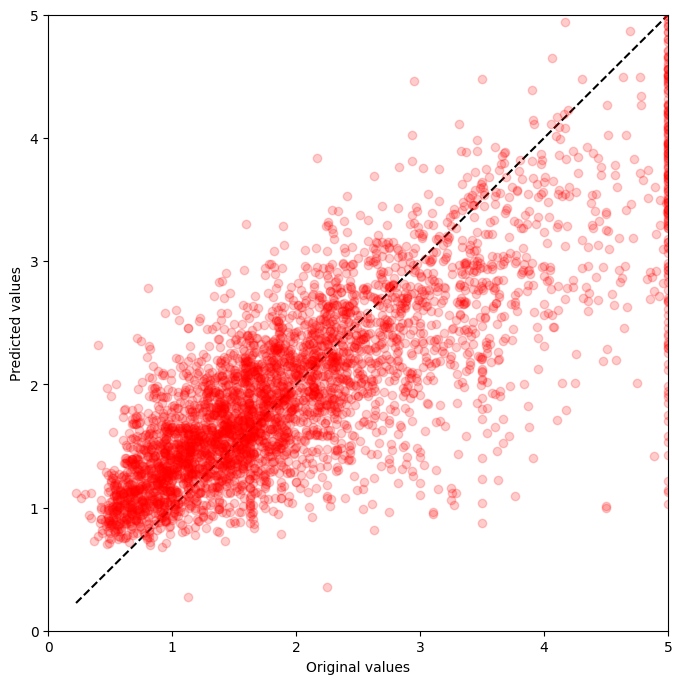

In [19]:

# Also plot the actual vs predicted value
plt.figure(figsize=(8,8))

ax = plt.gca()
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, prediction, 'ro', alpha=.2)
plt.xlabel('Original values')
plt.ylabel('Predicted values')

In [23]:
# # # Save the model to load in future
#%mkdir ExpModels/Exp5

#teacher_model.save('MlpTeacherModel/MlpTeacherModel')

INFO:tensorflow:Assets written to: MlpTeacherModel/MlpTeacherModel\assets


In [390]:
# Remark

# no scaling with out 2000 1000 epochs = 200 r2=0.62

# scaling with out 2000 1000 epochs = 300 r2=-3.2

# no scaling without out 2000 1000 epochs = 300 r2=0.65

# scaling without out 2000 1000 epochs = 300 r2=-21

# no scaling without out 2000 1000 epochs = 300 r2=-0.06

# no scaling without out 1000 500 epochs = 300 r2=0.66

# So far no scale no outlier seems perform better

# 1000 500 15 r2=-0.6

# 1000 500 16 r2=0.64

# 2000 1000 256 r2=0.617

# 2000 1000 128 r2=0.60

# 2000 1000 512 r2=-0.06

# 2000 500 256 r2=0.52

# 1024 512 128 r2=0.59

# 1024 256 1 r2=0.59


# 2000 1000 512 256 r2=0.644

# 2000 1000 512 256 64 r2=0.63

# 2000 1000 512 256 64 r2=0.62

# 2000 1000 512 128 r2=0.63

# 2000 1000 256 r2=0.60

# with drop out bad

############################### 2000 1000 512 256 with RobustScaler 0.66

# batch size 100 0.64

# batch size 50  0.64

# with feature selection
# [:,[0, 2, 3, 5]] 0.51